# Summary:
This notebook will cover obtaining cancer type information and gene information from abstracts. The aim is to annotate each abstract by cancer type and gene which are two critical features for the doctor recommendation system.

# Table of contents
* [1. Annotate cancer type information for each abstract](#Part1_link)
<br >&nbsp;&nbsp;&nbsp;[1.1 Tokenize abstracts](#Part1.1_link)
<br >&nbsp;&nbsp;&nbsp;[1.2 Annotate abstracts by cancer types](#Part1.2_link)
<br >&nbsp;&nbsp;&nbsp;[1.3 EDA cancer type information](#Part1.3_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.3.1 Summarize number of abstracts with/without cancer type information](#Part1.3.1_link)
<br >&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.3.2 Number of articles for each cancer type](#Part1.3.2_link)
* [2. Annotate gene information for each abstract](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Obtain cancer-related genes and aliases](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Annotate abstracts by gene](#Part2.2_link)

In [40]:
import pandas as pd
import numpy as np
import os
import gensim
import nltk
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from collections import defaultdict
import scipy
import requests
from bs4 import BeautifulSoup

<a id='Part1_link'></a>
# 1. Annotate cancer type information for each abstract

It is important to assign each abstract to cancer types, which reflect subspecialties of oncologists. 
<br>The cancer type information for each abstract can be simply identified by searching for cancer-related keywords.

<a id='Part1.1_link'></a>
## 1.1 Tokenize abstracts

In [9]:
base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
abstract_df=pd.read_csv(os.path.join(base_dir, 'data/abstract_citation_df_50930.csv'),index_col='pmid')

In [11]:
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”", 'analysis','analyses','analyzed','results','figures'
                "assayed", "assay", "assays","figures", "figure","data", "sample","samples","table","tables",
                'proteins','protein','cells','cell','genes','gene',
                'mutated','mutation','mutational','mutations','mutate','mutant','mutants',
                'cancer','cancers','tumor','tumors','variant','variants','biology','biological']
stop_words = set(list(stop_word1)+stop_word2+list(punct)+custom_words)   ## 493

In [12]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        temp=WordNetLemmatizer().lemmatize(token).lower()
        if len(temp)>1 and temp not in stop_words:
            result.append(temp)
    return result

In [16]:
abstract_df['abstract_processed']=abstract_df.abstract.apply(lambda x:preprocess(x))

In [17]:
abstract_df['abstract_counter']=abstract_df.abstract_processed.apply(lambda x:Counter(x))

In [18]:
abstract_df['unique_words']=abstract_df.abstract_counter.apply(lambda x:list(x.keys()))

<a id='Part1.2_link'></a>
## 1.2 Annotate abstracts by cancer types

In [1]:
def annotate_abstract(text):
    cancer_type=[]
    cancer_list1=['adrenocortical', 'anal', 'appendix', 'bladder', 'bone', 'breast', 'cervical', 'gallbladder', 'ovarian', 'penile', 'prostate', 'rectal', 'skin', 'thyroid', 'vaginal', 'vulvar', 'urethral', 'parathyroid',]
    cancer_list2=['carcinoid', 'pituitary', 'wilms', 'rhabdoid', 'brain']
    cancer_list3=['melanoma', 'mesothelioma', 'neuroblastoma', 'osteosarcoma', 'pheochromocytoma', 'retinoblastoma', 'rhabdomyosarcoma', 'sarcoma']
    for token in text:
        if token in cancer_list1:
            cancer_type.append(token.capitalize()+ ' Cancer')
        if token in cancer_list2:
            cancer_type.append(token.capitalize()+ ' Tumor')
        if token in cancer_list3:
            cancer_type.append(token.capitalize())
    if len(set(text).intersection(set(['bile','duct'])))==2:
        cancer_type.append('Bile Duct Cancer')
    if len(set(text).intersection(set(['colorectal', 'colon'])))>0:
        cancer_type.append('Colorectal Cancer')
    if len(set(text).intersection(set(['cardiac', 'heart'])))>0:
        cancer_type.append('Cardiac Tumors')
    if len(set(text).intersection(set(['endometrial', 'uterine', 'endometrium', 'uterus'])))>0:
        cancer_type.append('Endometrial Cancer')
    if len(set(text).intersection(set(['esophageal', 'esophagus'])))>0:
        cancer_type.append('Esophageal Cancer')
    if len(set(text).intersection(set(['ewing', 'sarcoma'])))==2:
        cancer_type.append('Ewing Sarcoma')
    if len(set(text).intersection(set(['fallopian', 'tube'])))==2:
        cancer_type.append('Fallopian Tube Cancer')
    if len(set(text).intersection(set(['gastric', 'stomach'])))>0:
        cancer_type.append('Gastric Cancer')
    if len(set(text).intersection(set(['gastrointestinal', 'stromal'])))>0:
        if len(set(text).intersection(set(['gastrointestinal', 'stromal'])))==2:
            cancer_type.append('Gastrointestinal Stromal Tumor (GIST)')
        else:
            cancer_type.append('Gastrointestinal Tumor')
    if len(set(text).intersection(set(['esthesioneuroblastoma', 'hypopharyngeal', 'laryngeal', 'nasopharyngeal', 'pharyngeal', 'salivary', 'oropharyngeal', 'neck'])))>0:
        cancer_type.append('Head and Neck Cancer')
    if len(set(text).intersection(set(['kidney', 'renal'])))>0:
        cancer_type.append('Kidney Cancer')
    if 'leukemia' in text:
        cancer_type.append('Leukemia')
        if 'acute' in text:
            if 'lymphoblastic' in text:
                cancer_type.append('Acute Lymphoblastic Leukemia (ALL)')
            if 'myeloid' in text:
                cancer_type.append('Acute Myeloid Leukemia (AML)')
        if 'chronic' in text:
            if 'lymphocytic' in text:
                cancer_type.append('Chronic Lymphocytic Leukemia (CLL)')
            if 'myelogenous' in text:
                cancer_type.append('Chronic Myelogenous Leukemia (CML)')
        if 'hairy' in text:
            cancer_type.append('Hairy Cell Leukemia')
    if len(set(text).intersection(set(['liver', 'hepatocellular', 'hepatocyte', 'hepatoblastoma'])))>0:
        cancer_type.append('Liver Cancer')
    if len(set(text).intersection(set(['lung', 'bronchial', 'pleuropulmonar', 'tracheobronchial'])))>0:
        cancer_type.append('Lung Cancer')
    if 'lymphoma' in text:
        cancer_type.append('Lymphoma')
        if 'burkitt' in text:
            cancer_type.append('Burkitt Lymphoma')
        if len(set(text).intersection(set(['mycosis', 'fungoides'])))==2:
            cancer_type.append('Mycosis Fungoides')
    if len(set(text).intersection(set(['multiple', 'myeloma'])))==2:
        cancer_type.append('Multiple Myeloma')
    if len(set(text).intersection(set(['myeloproliferative', 'myelodysplastic'])))>0:
        cancer_type.append('Myeloproliferative Neoplasms')
    if len(set(text).intersection(set(['pancreatic', 'pancreas'])))>0:
        cancer_type.append('Pancreatic Cancer')
    if len(set(text).intersection(set(['testicular', 'testicle', 'testicles', 'testis'])))>0:
        cancer_type.append('Testicular Cancer')
    return cancer_type

In [20]:
abstract_df['cancer_type']=abstract_df.unique_words.apply(lambda x:annotate_abstract(x))

In [21]:
cancer_list=set()
for i in abstract_df.cancer_type:
    for j in i:
        cancer_list.add(j)
cancer_list=list(cancer_list)
print('Number of unique cancer types: {}'.format(len(cancer_list)))

Number of unique cancer types: 55


<a id='Part1.3_link'></a>
## 1.3 EDA cancer type information

<a id='Part1.3.1_link'></a>
### 1.3.1 Summarize number of abstracts with/without cancer type information

In [22]:
cancertype_df=abstract_df.copy()
cancertype_df['pmid']=cancertype_df.index
cancertype_df['combined']=cancertype_df.apply(lambda row:[(row.pmid, s) for s in row['cancer_type']],axis=1)
cancertype_flattened=[c for pair in cancertype_df.combined for c in pair]
print(len(cancertype_flattened))
cancertype_flattened_df=pd.DataFrame.from_records(cancertype_flattened)
cancertype_flattened_df.columns=['pmid', 'cancer_type']
cancertype_flattened_df.head()

64853


,pmid,cancer_type
0,2357786,Multiple Myeloma
1,7512659,Rectal Cancer
2,7512659,Prostate Cancer
3,7523707,Prostate Cancer
4,7523707,Rectal Cancer


In [ ]:
cancertype_flattened_df.to_csv(os.path.join(base_dir, "data/cancertype_df2.csv"),index=False)

In [24]:
print('Number of abstracts have cancer type information: {}'.format(cancertype_flattened_df.pmid.nunique()))
print("Number of abstracts don't have cancer type information: {}".format(abstract_df.shape[0]-cancertype_flattened_df.pmid.nunique()))

Number of abstracts have cancer type information: 42455
Number of abstracts don't have cancer type information: 8475


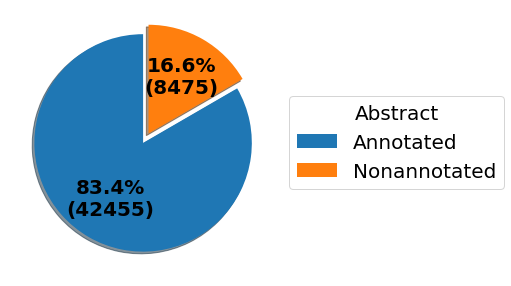

In [25]:
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(aspect="equal"))

annot = ["42455 Annotated",
          "8475 Nonannotated"]
explode = (0, 0.1)
data = [float(x.split()[0]) for x in annot]
abstract = [x.split()[-1] for x in annot]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data), explode=explode, shadow=True, startangle=90,
                                  textprops=dict(color="black"))

ax.legend(wedges, abstract,
          title="Abstract",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
          fontsize=20,
          title_fontsize=20)

plt.setp(autotexts, size=20, weight="bold")
#ax.set_title("Matplotlib bakery: A pie")

plt.show()

**Note**: Although around 83.4% of abstracts have clear cancer type information, it is still important to annotate the remaining 16.6% as the final recommendation system will first filter abstracts according to cancer types. It is possible that oncologists with important research findings will be eliminated from the first round filtering if the cancer type information is missing.

<a id='Part1.3.2_link'></a>
### 1.3.2 Number of articles for each cancer type

In [27]:
cancertype_counts = cancertype_flattened_df.cancer_type.value_counts().reset_index().rename(columns={'cancer_type':'counts','index':'cancer_type'}).sort_values(by=['counts'],ascending=False)
cancertype_counts.head()


,cancer_type,counts
0,Breast Cancer,7757
1,Lung Cancer,5201
2,Leukemia,4755
3,Prostate Cancer,3878
4,Colorectal Cancer,3412


Text(0.5, 1.0, 'Number of articles in each cancer type')

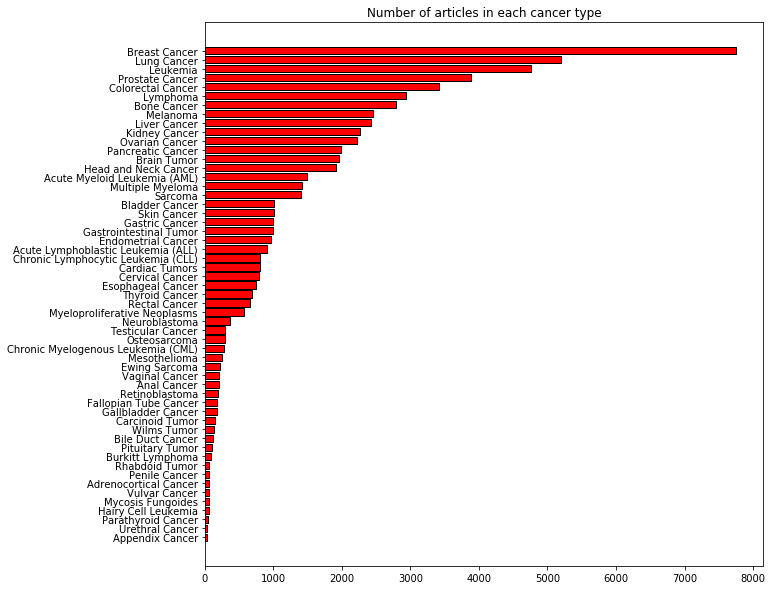

In [29]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.barh(np.arange(55),cancertype_counts.counts.values,edgecolor='black',color='red')

ax.set_yticks(np.arange(55))
ax.set_yticklabels(cancertype_counts.cancer_type.values)
ax.invert_yaxis()
ax.set_title('Number of articles in each cancer type')

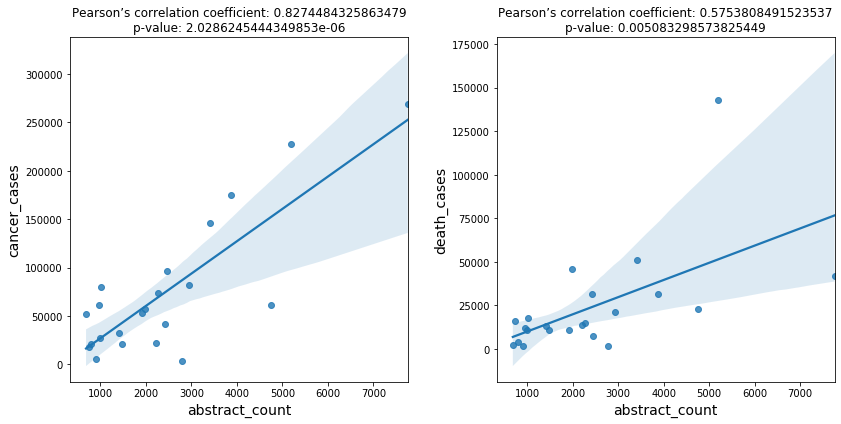

In [32]:
fig, axes = plt.subplots(1,2,figsize = (12,6))
cancer_statistics=pd.read_csv(os.path.join(base_dir, 'data/cancer_statistics.csv'))

coef1, p1 = scipy.stats.pearsonr(cancer_statistics.counts1, cancer_statistics.new_cases)
coef2, p2 = scipy.stats.pearsonr(cancer_statistics.counts1, cancer_statistics.death_cases)

sns.regplot(x='counts1',y='new_cases',data=cancer_statistics,ax=axes[0])
axes[0].set_xlabel('abstract_count', fontsize=14)
axes[0].set_ylabel('cancer_cases', fontsize=14)
axes[0].set_title('Pearson’s correlation coefficient: {}\np-value: {}'.format(coef1, p1), fontsize=12)

sns.regplot(x='counts1',y='death_cases',data=cancer_statistics,ax=axes[1])
axes[1].set_xlabel('abstract_count', fontsize=14)
axes[1].set_ylabel('death_cases', fontsize=14)
axes[1].set_title('Pearson’s correlation coefficient: {}\np-value: {}'.format(coef2, p2), fontsize=12)

plt.tight_layout()

Based on the correlation plots above, there is positive correlation between the numebr of abstracts and the number of cancer cases/ death cases for each cancer type.

<a id='Part2_link'></a>
# 2. Annotate gene information for each abstract

The second important feature for abstracts is gene information. The majority of cancers are caused by alterations in genes and targeted therapies are designed based on gene mutation profiles.

<a id='Part2.1_link'></a>
## 2.1 Obtain cancer-related genes and aliases

Here we are only interested in cancer-related genes. Thus, genes that have been annotated to be cancer-relevant are obtained from **OncoKB** https://www.oncokb.org/.

In [34]:
oncokb_df=pd.read_csv(os.path.join(base_dir,'data/cancerGeneList.tsv'),sep='\t')
oncokb_df=oncokb_df.sort_values(by=['Hugo Symbol'])
oncokb_df=oncokb_df[oncokb_df['OncoKB Annotated']=='Yes']
gene_list=oncokb_df['Hugo Symbol'].values
print(len(gene_list))

669


Every gene may have multiple aliases/synonyms. To simplify the annotation process, the gene names are converted to the HGNC format. The gene alias information can be obtained from https://ghr.nlm.nih.gov/gene.
<br>**Note**: For BRCA1 and BRCA2, since they are usually discussed together in literature as BRCA1/2, BRCA1/2 will be used to replace BRCA1 and BRCA2.

In [36]:
def extract_gene_info(gene_list):
    gene_dict=defaultdict(list)
    base_url='https://ghr.nlm.nih.gov/gene/{}#synonyms'
    for gene in gene_list:
        search_url=base_url.replace("{}",gene)
    
        # get html of search results page
        html = requests.get(search_url).content
        soup = BeautifulSoup(html,'html.parser')
        ## get list of gene alias
        genes = soup.find_all('div',{'class':'col-md-8'})
        if len(genes) ==4:
            genes=genes[3]
            for i in genes.find_all('li'):
                gene_dict[gene].append(i.get_text())
    return gene_dict

In [41]:
alias_dict=extract_gene_info(gene_list)

In [42]:
alias_dict['BRCA1/2'].append('BRCA')
alias_dict['BRCA1/2'].append('BRCA1/2')

In [43]:
del alias_dict['BRCA1']
del alias_dict['BRCA2']

In [46]:
alias_dict.keys()

dict_keys(['ABL1', 'ACTG1', 'ACVR1', 'AKT1', 'AKT2', 'AKT3', 'ALB', 'ALK', 'ALOX12B', 'AMER1', 'ANKRD11', 'APC', 'AR', 'ARID1A', 'ARID1B', 'ARID2', 'ARID5B', 'ASXL1', 'ASXL2', 'ATF1', 'ATM', 'ATP6AP1', 'ATP6V1B2', 'ATR', 'ATRX', 'ATXN2', 'ATXN7', 'AURKB', 'AXIN1', 'AXIN2', 'AXL', 'B2M', 'BAP1', 'BCL10', 'BCL11B', 'BCL2', 'BCL6', 'BCL9', 'BCOR', 'BCORL1', 'BCR', 'BIRC3', 'BLM', 'BMPR1A', 'BRAF', 'BRD4', 'BRIP1', 'BTG1', 'BTK', 'CALR', 'CARD11', 'CASP8', 'CBFB', 'CBL', 'CCND1', 'CCND2', 'CD274', 'CD28', 'CD58', 'CD79A', 'CD79B', 'CDC42', 'CDC73', 'CDH1', 'CDK12', 'CDK4', 'CDK6', 'CDKN1B', 'CDKN2A', 'CEBPA', 'CHEK2', 'CIC', 'CIITA', 'CRBN', 'CREB1', 'CREBBP', 'CSF1R', 'CSF3R', 'CTCF', 'CTLA4', 'CTNNB1', 'CUL3', 'CUX1', 'CXCR4', 'CYLD', 'CYP19A1', 'DDIT3', 'DDR2', 'DDX3X', 'DEK', 'DICER1', 'DNMT1', 'DNMT3A', 'DNMT3B', 'DOT1L', 'DROSHA', 'EED', 'EGFR', 'EIF4E', 'EP300', 'EPAS1', 'EPCAM', 'EPHA3', 'EPOR', 'ERBB2', 'ERBB3', 'ERBB4', 'ERCC2', 'ERCC3', 'ERCC4', 'ERCC5', 'ERF', 'ERG', 'ESCO2', '

Further processing gene aliases.

In [47]:
alias_df = pd.DataFrame.from_dict(alias_dict, orient='index')
alias_df['HGNC']=alias_df.index
alias_df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,HGNC
ABL1,Abelson tyrosine-protein kinase 1,ABL,bcr/abl,bcr/c-abl oncogene protein,c-ABL,"c-abl oncogene 1, receptor tyrosine kinase",c-ABL1,JTK7,p150,proto-oncogene c-Abl,...,None,None,None,None,None,None,None,None,None,ABL1
ACTG1,ACT,ACTG,ACTG_HUMAN,actin-like protein,"actin, cytoplasmic 2","actin, gamma 1",cytoskeletal gamma-actin,"deafness, autosomal dominant 20","deafness, autosomal dominant 26",DFNA20,...,None,None,None,None,None,None,None,None,None,ACTG1
ACVR1,activin A receptor type I,"activin A receptor, type I","activin A receptor, type II-like kinase 2",activin A type I receptor,activin A type I receptor precursor,"ActR-IA protein, human",ACTRI,ACVR1_HUMAN,ACVR1A,ACVRLK2,...,None,None,None,None,None,None,None,None,None,ACVR1
AKT1,AKT,AKT1_HUMAN,MGC99656,PKB,PKB-ALPHA,PKB alpha,PRKBA,protein kinase B alpha,proto-oncogene c-Akt,RAC,...,None,None,None,None,None,None,None,None,None,AKT1
AKT2,HIHGHH,PKBB,PKBBETA,PRKBB,RAC-BETA,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,AKT2


In [48]:
alias_df=pd.DataFrame({'HGNC':np.array(list(alias_dict.keys())),'alias_list':list(alias_dict.values())})
alias_df.apply(lambda x:x['alias_list'].append(x['HGNC']),axis=1)
alias_df['combined']=alias_df.apply(lambda row:[(row['HGNC'], s) for s in row['alias_list']],axis=1)

alias_flattened=[a for pair in alias_df.combined for a in pair]
alias_flattened_df=pd.DataFrame.from_records(alias_flattened)
alias_flattened_df.columns=['HGNC', 'alias']
alias_flattened_df['alias_lower']=alias_flattened_df.alias.apply(lambda x:x.lower())
alias_flattened_df.head()

,HGNC,alias,alias_lower
0,ABL1,Abelson tyrosine-protein kinase 1,abelson tyrosine-protein kinase 1
1,ABL1,ABL,abl
2,ABL1,bcr/abl,bcr/abl
3,ABL1,bcr/c-abl oncogene protein,bcr/c-abl oncogene protein
4,ABL1,c-ABL,c-abl


In [49]:
print('Number of unique HGNC: {}'.format(alias_flattened_df.HGNC.nunique()))

Number of unique HGNC: 421


In [50]:
alias_dict2={}
for i in range(len(alias_flattened_df)):
    alias_dict2[alias_flattened_df.iloc[i,2]]=alias_flattened_df.iloc[i,0]

<a id='Part2.2_link'></a>
## 2.2 Annotate abstracts by gene

In [51]:
abstract_df['alias_set']=abstract_df.unique_words.apply(lambda x:set(alias_flattened_df.alias_lower.values).intersection(set(x)))

In [52]:
abstract_df['HGNC_set']=abstract_df.alias_set.apply(lambda x:set([alias_dict2.get(i) for i in x]))

In [53]:
HGNC_df=abstract_df.copy()
HGNC_df['pmid']=HGNC_df.index
HGNC_df['combined']=HGNC_df.apply(lambda row:[(row.pmid, s) for s in row['HGNC_set']],axis=1)
HGNC_flattened=[c for pair in HGNC_df.combined for c in pair]
print(len(HGNC_flattened))
HGNC_flattened_df=pd.DataFrame.from_records(HGNC_flattened)
HGNC_flattened_df.columns=['pmid', 'HGNC']
HGNC_flattened_df.head()

31530


,pmid,HGNC
0,9306419,BCR
1,9306419,ABL1
2,10037348,DNMT1
3,10079468,BCR
4,10079468,ABL1


In [ ]:
HGNC_flattened_df.to_csv(os.path.join(base_dir, "data/HGNC_df2.csv"),index=False)

In [54]:
print('Number of articles with gene information: {}'.format(HGNC_flattened_df.pmid.nunique()))
print('Number of unique genes: {}'.format(HGNC_flattened_df.HGNC.nunique()))

Number of articles with gene information: 20448
Number of unique genes: 206


In [55]:
HGNC_counts = HGNC_flattened_df.HGNC.value_counts().to_frame().reset_index().rename(columns={'HGNC':'counts', 'index':'HGNC'})
HGNC_counts.head()

,HGNC,counts
0,CTLA4,2870
1,DNMT1,1893
2,EGFR,1835
3,ESR1,1611
4,MET,1518


Text(0.5, 1.0, 'Number of occurrences for top20 frequent genes ')

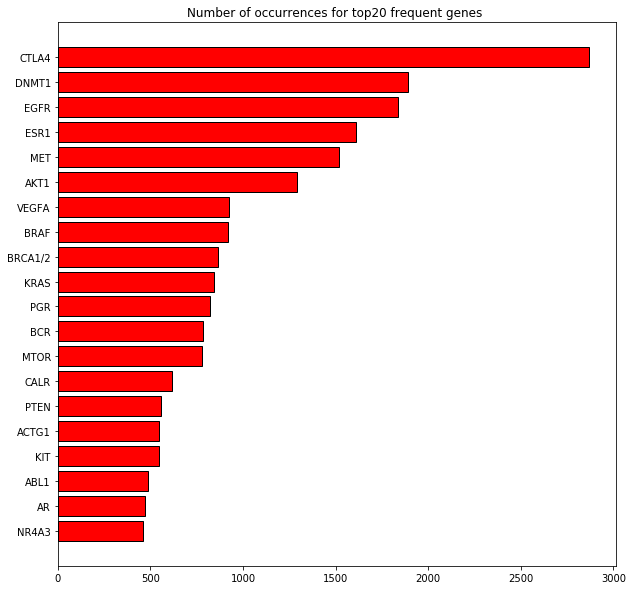

In [57]:
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.barh(np.arange(20),HGNC_counts.counts.values[:20],edgecolor='black',color='red')

ax.set_yticks(np.arange(20))
ax.set_yticklabels(HGNC_counts.HGNC.values[:20])
ax.invert_yaxis()
ax.set_title('Number of occurrences for top20 frequent genes ')

The most frequent gene in abstracts is **CTLA4**, which is involved in immune response. CTLA-4 blockade (eg. by **Ipilimumab**) can reactivate immune cells and thereby cure cancer in some patients. The Nobel Prize in Medicine in 2018 was awarded for discovery of CTLA-4 and PD-1 (another target in regulating immune response).